# convolutional net  
a conv net to learn the ssim scores of image reconstruction.

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import progressbar
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
%matplotlib inline

### neural net functons

In [3]:
def convolve_inner_layers(x, W, b):
    '''
    inner layers of network --- tanh activation
    '''
    y = tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='VALID')
    y = tf.nn.bias_add(y, b)
    return tf.nn.tanh(y)

def convolve_ouput_layer(x, W, b):
    '''
    output layer of network --- linear activation
    '''
    y = tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='VALID')
    y = tf.nn.bias_add(y, b)
    return y

def conv_net(x, W, b):
    '''
    entire conv net. each layer feed to following layer as well as output layer
    '''
    conv1 = convolve_inner_layers(x, W['weights1'], b['bias1'])
    conv2 = convolve_inner_layers(conv1, W['weights2'], b['bias2'])
    conv3 = convolve_inner_layers(conv2, W['weights3'], b['bias3'])
    output_feed = tf.concat([conv1, conv2, conv3],3)
    output = convolve_ouput_layer(output_feed, W['weights_out'], b['bias_out'])
    return output

### data processing functions

In [4]:
def get_variance(training_target):
    '''
    returns variance of the target data. used in normalizing the error.
    '''
    all_pixels = training_target.flatten()
    return all_pixels.var()

def normalize_input(train_data, test_data):
    '''
    normailizing input across each pixel an each channel (i.e. normalize for each input to network).
    '''
    mean, std_dev = np.mean(train_data, axis=0), np.std(train_data, axis=0)
    return (train_data - mean) / std_dev, (test_data - mean) / std_dev

def get_epoch(x, y, n):
    '''
    splits entire data set into an epoch with minibatch of size n. returns a dict with key being the 
    minibatch number and the value being a length 2 list with the features in first index and 
    targets in the second.
    '''
    input_size = x.shape[0]
    number_batches = input_size // n
    extra_examples = input_size % n
    batches = {}
    batch_indices = np.arange(input_size)
    np.random.shuffle(batch_indices)
    for i in range(number_batches):
        temp_indices = batch_indices[n*i:n*(i+1)]
        temp_x = []
        temp_y = []
        for j in temp_indices:
            temp_x.append(x[j])
            temp_y.append(y[j])
        batches[i] = [np.asarray(temp_x), np.asarray(temp_y)]
    if extra_examples != 0:
        extra_indices = batch_indices[input_size-extra_examples:input_size]
        temp_x = []
        temp_y = []
        for k in extra_indices:
            temp_x.append(x[k])
            temp_y.append(y[k])
        batches[i+1] = [np.asarray(temp_x), np.asarray(temp_y)]
    return batches

### network set up

In [5]:
filter_dim, filter_dim2 = 11, 1
batch_size = 4
image_dim, result_dim = 96, 86
input_layer, first_layer, second_layer, third_layer, output_layer = 4, 17, 9, 4, 1
learning_rate = .01
epochs = 300

In [6]:
# data input
data_path = 'https://raw.githubusercontent.com/michaelneuder/image_quality_analysis/master/data/sample_data/'

# train data --- 500 images, 96x96 pixels
orig_500 = pd.read_csv('{}orig_500.txt'.format(data_path), header=None, delim_whitespace = True)
recon_500 = pd.read_csv('{}recon_500.txt'.format(data_path), header=None, delim_whitespace = True)

# test data --- 140 images, 96x96 pixels
orig_140 = pd.read_csv('{}orig_140.txt'.format(data_path), header=None, delim_whitespace = True)
recon_140 = pd.read_csv('{}recon_140.txt'.format(data_path), header=None, delim_whitespace = True)

# train target --- 500 images, 86x86 pixels (dimension reduction due no zero padding being used)
ssim_500 = pd.read_csv('{}ssim_500_nogauss.csv'.format(data_path), header=None)
ssim_140 = pd.read_csv('{}ssim_140_nogauss.csv'.format(data_path), header=None)

now we have the raw data, we want to get the inputs normalized and shaped correctly.

In [7]:
# getting 4 input channels for train and test --- (orig, recon, orig squared, recon squared)
original_images_train = orig_500.values
original_images_train_sq = orig_500.values**2
reconstructed_images_train = recon_500.values
reconstructed_images_train_sq = recon_500.values**2

original_images_test = orig_140.values
original_images_test_sq = orig_140.values**2
reconstructed_images_test = recon_140.values
reconstructed_images_test_sq = recon_140.values**2

# stack inputs
training_input = np.dstack((original_images_train, reconstructed_images_train, original_images_train_sq, reconstructed_images_train_sq))
testing_input = np.dstack((original_images_test, reconstructed_images_test, original_images_test_sq, reconstructed_images_test_sq))

# normalize inputs
training_input_normalized, testing_input_normalized = normalize_input(training_input, testing_input)

# target values
training_target = ssim_500.values
testing_target = ssim_140.values

In [8]:
# get size of training and testing set
train_size = original_images_train.shape[0]
test_size = original_images_test.shape[0]

# reshaping features to (num images, 96x96, 4 channels)
train_features = np.reshape(training_input_normalized, [train_size,image_dim,image_dim,input_layer])
test_features =  np.reshape(testing_input_normalized, [test_size,image_dim,image_dim,input_layer])

# reshaping target to --- (num images, 86x86, 1)
train_target = np.reshape(training_target, [train_size, result_dim, result_dim, output_layer])
test_target = np.reshape(testing_target, [test_size, result_dim, result_dim, output_layer])

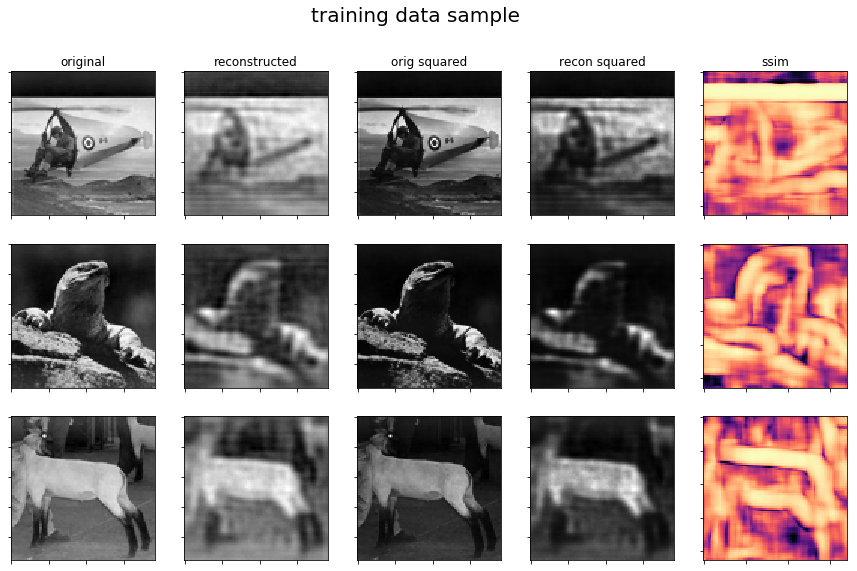

In [9]:
f, axarr = plt.subplots(nrows=3,ncols=5, figsize=(15,9))
for i in range(3):
    axarr[i,0].imshow(train_features[i,:,:,0], cmap='gray')
    axarr[i,1].imshow(train_features[i,:,:,1], cmap='gray')
    axarr[i,2].imshow(train_features[i,:,:,2], cmap='gray')
    axarr[i,3].imshow(train_features[i,:,:,3], cmap='gray')
    axarr[i,4].imshow(train_target[i,:,:,0], cmap='magma')

axarr[0,0].set_title('original')
axarr[0,1].set_title('reconstructed')
axarr[0,2].set_title('orig squared')
axarr[0,3].set_title('recon squared')
axarr[0,4].set_title('ssim')
for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('training data sample', size=20)
plt.show()

training data looks good! lets take a quick look at test data to make sure no diabolic activity is occuring.

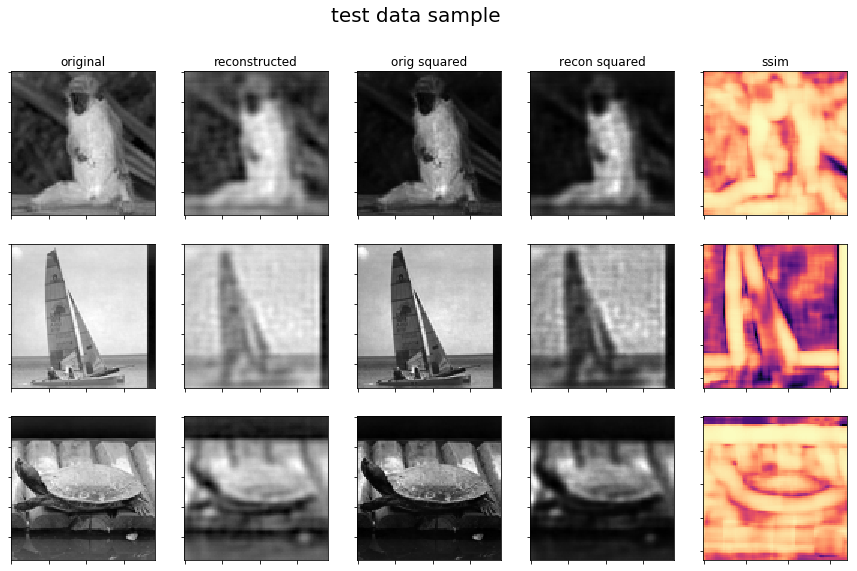

In [10]:
f, axarr = plt.subplots(nrows=3,ncols=5, figsize=(15,9))
for i in range(3):
    axarr[i,0].imshow(test_features[i,:,:,0], cmap='gray')
    axarr[i,1].imshow(test_features[i,:,:,1], cmap='gray')
    axarr[i,2].imshow(test_features[i,:,:,2], cmap='gray')
    axarr[i,3].imshow(test_features[i,:,:,3], cmap='gray')
    axarr[i,4].imshow(test_target[i,:,:,0], cmap='magma')

axarr[0,0].set_title('original')
axarr[0,1].set_title('reconstructed')
axarr[0,2].set_title('orig squared')
axarr[0,3].set_title('recon squared')
axarr[0,4].set_title('ssim')
for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('test data sample', size=20)
plt.show()

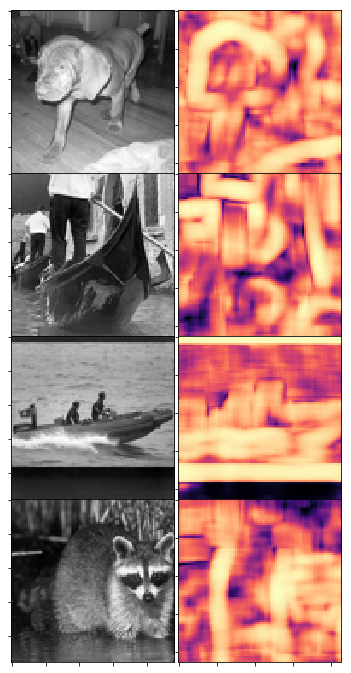

In [60]:
import matplotlib.gridspec as gridspec
plt.figure(figsize = (6,12))
gs1 = gridspec.GridSpec(4, 2)
gs1.update(wspace=0, hspace=0)

for i in range(4):
    x = np.random.randint(141)
    ax1, ax2 = plt.subplot(gs1[2*i]), plt.subplot(gs1[2*i+1])
#     ax1, ax2, ax3 = plt.subplot(gs1[3*i]), plt.subplot(gs1[3*i+1]), plt.subplot(gs1[3*i+2])
    for ax in [ax1, ax2]:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    ax1.imshow(test_features[x,:,:,0], cmap='gray')
    ax2.imshow(test_target[x,:,:,0], cmap='magma')

# f, axarr = plt.subplots(nrows=3,ncols=3, figsize=(9,9))
# for i in range(3):
#     x = np.random.randint(141)
#     axarr[i,0].imshow(test_features[x,:,:,0], cmap='gray')
#     axarr[i,1].imshow(test_features[x,:,:,1], cmap='gray')
#     axarr[i,2].imshow(test_target[x,:,:,0], cmap='magma')
# for ax_row in axarr:
#     for ax in ax_row:
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])
plt.show()

testing data looks good too. lets get this thing rolling.

In [13]:
# initializing filters, this is what we are trying to learn --- fan in
scaling_factor = 1.0
initializer = tf.contrib.layers.variance_scaling_initializer(factor=scaling_factor, mode='FAN_IN')
weights = {
    'weights1': tf.get_variable('weights1', [filter_dim,filter_dim,input_layer,first_layer], initializer=initializer),
    'weights2': tf.get_variable('weights2', [filter_dim2,filter_dim2,first_layer,second_layer], initializer=initializer),
    'weights3': tf.get_variable('weights3', [filter_dim2,filter_dim2,second_layer,third_layer], initializer=initializer),
    'weights_out': tf.get_variable('weights4', [filter_dim2,filter_dim2,third_layer+second_layer+first_layer,output_layer], initializer=initializer)
}
biases = {
    'bias1': tf.get_variable('bias1', [first_layer], initializer=initializer),
    'bias2': tf.get_variable('bias2', [second_layer], initializer=initializer),
    'bias3': tf.get_variable('bias3', [third_layer], initializer=initializer),
    'bias_out': tf.get_variable('bias4', [output_layer], initializer=initializer)
}

In [14]:
# tensorflow setup
x = tf.placeholder(tf.float32, [None, image_dim, image_dim, input_layer])
y = tf.placeholder(tf.float32, [None, result_dim, result_dim, output_layer])

# model
prediction = conv_net(x, weights, biases)

# get variance to normalize error terms during training
variance = get_variance(train_target)

# loss and optimization
cost = tf.reduce_mean(tf.square(tf.subtract(prediction, y)))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
init = tf.global_variables_initializer()

In [15]:
# error arrays
training_error, testing_error = [], []
epoch_time = np.asarray([])

# tensorflow session & training
with tf.Session() as sess:
    sess.run(init)
    global_start_time = time.time()
    epoch_count = -1
    for epoch in range(2000):
        epoch_count += 1
        start_time = time.time()
        epoch = get_epoch(train_features, train_target, batch_size)
        for i in epoch:
            x_data_train, y_data_train = np.asarray(epoch[i][0]), np.asarray(epoch[i][1])
            sess.run(optimizer, feed_dict={x : x_data_train, y : y_data_train})
            train_loss = sess.run(cost, feed_dict={x : x_data_train, y : y_data_train})
        training_error.append(100*train_loss/variance)
        test_loss = sess.run(cost, feed_dict={x : test_features, y : test_target})
        testing_error.append(100*test_loss/variance)
        end_time = time.time()
        epoch_time = np.append(epoch_time, end_time-start_time)
        print('current epoch: {} -- '.format(epoch_count)
              +'current train error: {:.4f} -- '.format(100*train_loss/variance)
              +'average epoch time: {:.4}s '.format(epoch_time.mean()), end='\r')         

KeyboardInterrupt: 

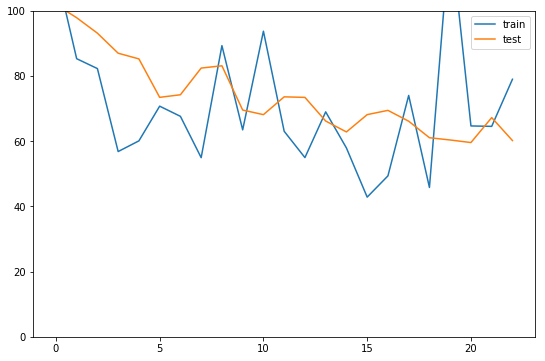

In [16]:
f, axarr = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
axarr.plot(np.arange(len(training_error)), training_error, label='train')
axarr.plot(np.arange(len(testing_error)), testing_error, label='test')
axarr.legend()
axarr.set_ylim(0,100)
plt.savefig('test.png')